In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit
import datetime

## Read the file

In [2]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, ion4_top, \
    ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, ion6_bottom, \
    ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, 
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

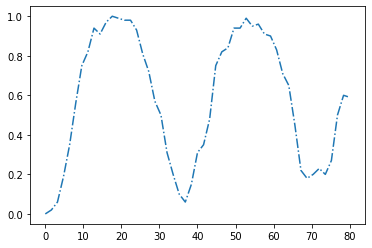

In [4]:
x, prob = readFile('time_scan_counter_prop_rfsoc_dressed_states_1_005')
plt.plot(x, prob, '-.')

In [3]:
import pandas as pd
df_data = pd.read_excel('data.xlsx')
df_data

Frequency (MHz)                                            state 0  \
0          190.688  freq_scan_counter_prop_rfsoc_dressed_states_1_012   
1          198.469  time_scan_counter_prop_rfsoc_dressed_states_1_001   
2          206.264  time_scan_counter_prop_rfsoc_dressed_states_1_005   

                                             state 1  \
0  freq_scan_counter_prop_rfsoc_dressed_states_1_013   
1  time_scan_counter_prop_rfsoc_dressed_states_1_002   
2  time_scan_counter_prop_rfsoc_dressed_states_1_006   

                                             state 2  \
0  freq_scan_counter_prop_rfsoc_dressed_states_1_014   
1  time_scan_counter_prop_rfsoc_dressed_states_1_003   
2  time_scan_counter_prop_rfsoc_dressed_states_1_007   

                                             state 3  
0  freq_scan_counter_prop_rfsoc_dressed_states_1_015  
1  time_scan_counter_prop_rfsoc_dressed_states_1_004  
2  time_scan_counter_prop_rfsoc_dressed_states_1_008

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

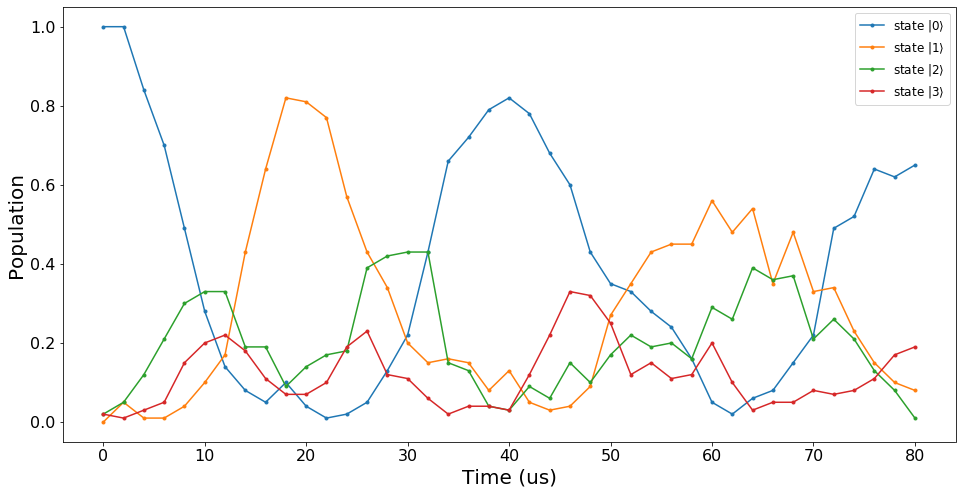

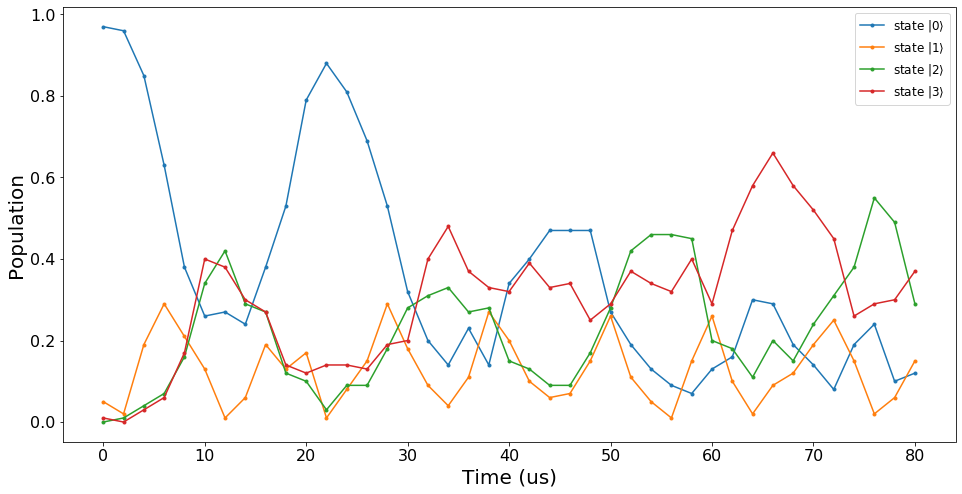

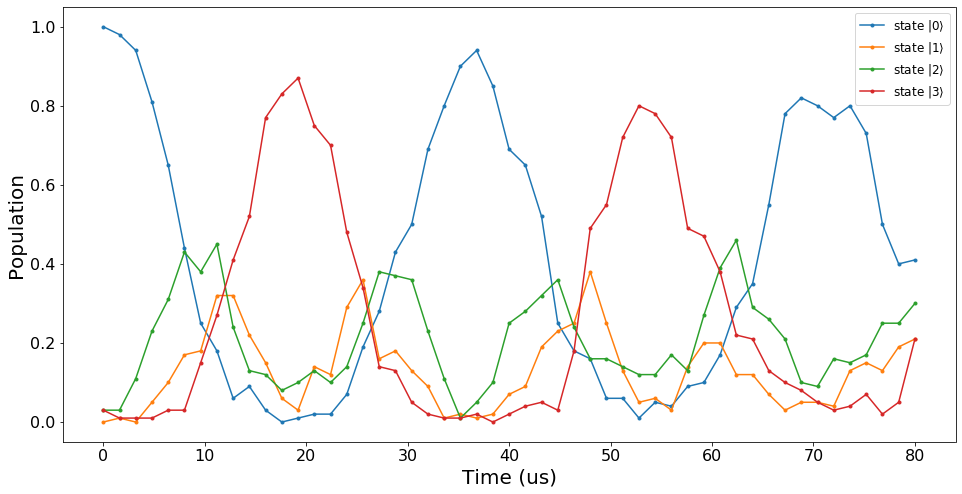

In [6]:
for i in range(len(df_data.index)):
    x, Prob0_inv = readFile(df_data['state 0'][i])
    x, Prob1_inv = readFile(df_data['state 1'][i])
    x, Prob2_inv = readFile(df_data['state 2'][i])
    x, Prob3_inv = readFile(df_data['state 3'][i])
    plt.figure(figsize = [16,8])
    plt.plot(x, 1-Prob0_inv, '.-', label = r'state $|0\rightangle$')
    plt.plot(x, 1-Prob1_inv, '.-', label = r'state $|1\rightangle$')
    plt.plot(x, 1-Prob2_inv, '.-', label = r'state $|2\rightangle$')
    plt.plot(x, 1-Prob3_inv, '.-', label = r'state $|3\rightangle$')
    plt.legend()
    plt.xlabel('Time (us)')
    plt.ylabel('Population')

In [7]:
class Zeeman:
    def __init__(self, 
                 w0 = 0,
                 w1 = 0,
                 w2 = 0,
                 w3 = 0,
                 omega1 = 0,
                 omega2 = 0,
                 gamma1 = 0,
                 gamma2 = 0,
                 gamma3 = 0,
                 s_init = ket2dm(basis(4,1))
                ):
        self.w0 = w0
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.omega1 = omega1
        self.omega2 = omega2
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.gamma3 = gamma3
        self.s_init = s_init
        self.output = None
        
    def solve(self, tlist):
        H0 = self.w0 * basis(4,0) * basis(4,0).dag()\
            + self.w1 * basis(4,1)* basis(4,1).dag() \
            + self.w2 * basis(4,2)* basis(4,2).dag()\
            + self.w3 * basis(4,3)* basis(4,3).dag()
        
        H_int = self.omega1 * (basis(4,1) * basis(4,2).dag() + basis(4,2) * basis(4,1).dag())\
            + self.omega2 * (basis(4,1) * basis(4,3).dag() + basis(4,3) * basis(4,1).dag())
        
        H = [H0, H_int]
        
        c_ops = [np.sqrt(self.gamma1)*basis(4,1)* basis(4,1).dag(), 
                 np.sqrt(self.gamma2)*basis(4,2)* basis(4,2).dag(), 
                 np.sqrt(self.gamma3)*basis(4,3)* basis(4,3).dag()]
            
        e_ops = []
        
        opts = Options(normalize_output=False)
        self.output = mesolve(H, self.s_init, tlist, c_ops, e_ops, options = opts)
    
    def time_scan(self,
                  t_start,
                  t_stop,
                  Nsample,
                  isPlot = True
                 ):

        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        states = self.output.states
        s0,s1,s2,s3= self.measure(states, self.output.times, isPlot)
        return s0,s1,s2,s3
    def measure(self, states, x_axis, isPlot = True):
        # states: np.array of dm includes two ions and phonons
        s_0 = basis(4, 0)*basis(4, 0).dag() # State 0
        s_1 = basis(4, 1)*basis(4, 1).dag() # State 1
        s_2 = basis(4, 2)*basis(4, 2).dag() # State 2
        s_3 = basis(4, 3)*basis(4, 3).dag() # State 3

        def _measure(state, s_meas):
            result = (state*s_meas).tr()
            return np.real(result)
            
        s0 = np.zeros(len(states))
        s1 = np.zeros(len(states))
        s2 = np.zeros(len(states))
        s3 = np.zeros(len(states))

        for i in range(len(states)):
            s0[i] = _measure(states[i], s_0)
            s1[i] = _measure(states[i], s_1)
            s2[i] = _measure(states[i], s_2)
            s3[i] = _measure(states[i], s_3)
        if isPlot:
            fig, ax = plt.subplots(figsize = [10,6])
#             ax.plot(x_axis, s0, label = 's0')
            ax.plot(x_axis, s1, label = 's1')
            ax.plot(x_axis, s2, label = 's2')
            ax.plot(x_axis, s3, label = 's3')
            ax.set_xlabel('Time (us)')
            ax.set_ylabel(r'Population')
            ax.legend()
            ax.set_ylim(-0.05,1.05)
        return s0,s1,s2,s3

# Initial state 1

In [8]:
def error(_data):
    data = np.array(_data)
    return np.array(np.sqrt((np.sqrt(abs(data)*(1-abs(data))/100))**2+0.01**2))

Text(0, 0.5, 'Population')

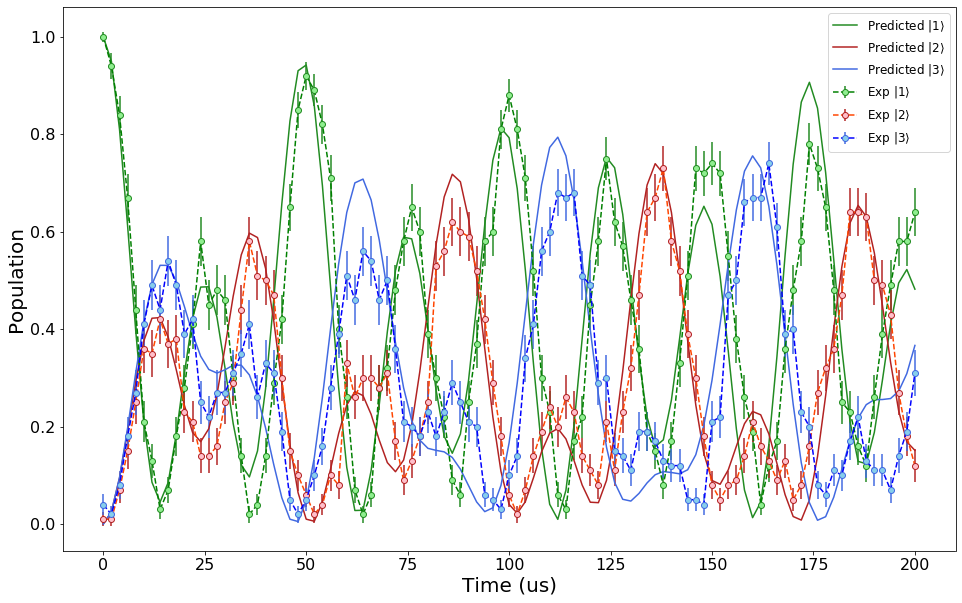

In [9]:
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1e-1, # MHz
             w3 = 0, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1)))
s0,s1,s2,s3 = exp.time_scan(0, 200, 101, isPlot = False)

i = 0
x, Prob1_inv = readFile(df_data['state 1'][i])
x, Prob2_inv = readFile(df_data['state 2'][i])
x, Prob3_inv = readFile(df_data['state 3'][i])
Prob1 = 1-Prob1_inv
Prob2 = 1-Prob2_inv
Prob3 = 1-Prob3_inv
err_Prob1 = error(Prob1)
err_Prob2 = error(Prob2)
err_Prob3 = error(Prob3)

plt.figure(figsize = [16,10])
plt.errorbar(x, Prob1, err_Prob1,
             ls='--',color = 'green', marker='o',mec='forestgreen', ecolor='forestgreen',mfc='lightgreen', 
                 label = r'Exp $|1\rightangle$')
plt.plot(x, s1, '-', color = 'forestgreen', label = r'Predicted $|1\rightangle$')
plt.errorbar(x, Prob2, err_Prob2,
         ls='--',color = 'orangered', marker='o',mec='firebrick', ecolor='firebrick',mfc='pink', 
             label = r'Exp $|2\rightangle$')
plt.plot(x, s2, '-', color = 'firebrick', label = r'Predicted $|2\rightangle$')
plt.errorbar(x, Prob3, err_Prob3,
         ls='--',color = 'blue', marker='o',mec='royalblue', ecolor='royalblue',mfc='skyblue',
             label = r'Exp $|3\rightangle$')
plt.plot(x, s3, '-', color = 'royalblue', label = r'Predicted $|3\rightangle$')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Population')

# Initial state 2

Text(0, 0.5, 'Population')

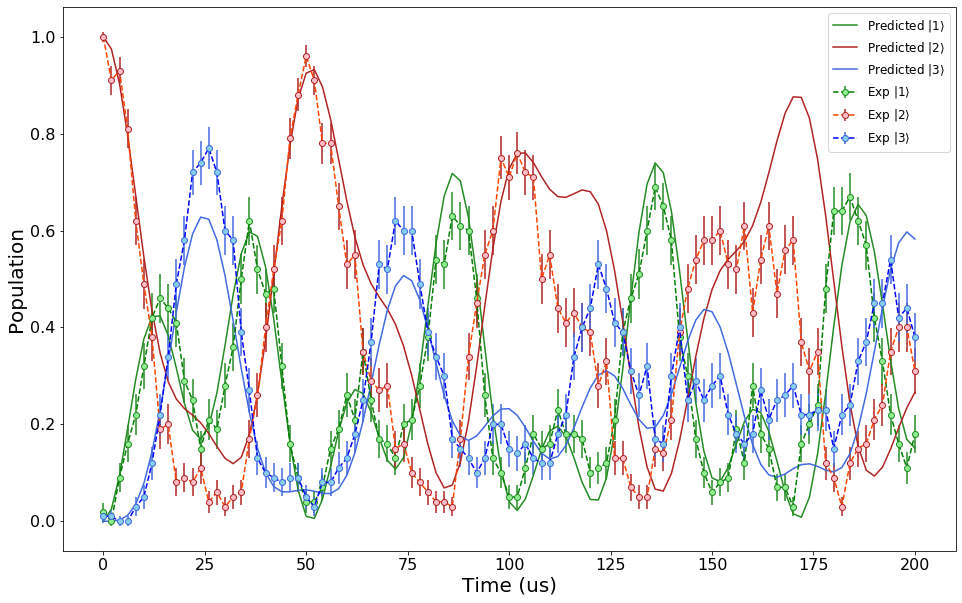

In [94]:
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1.0e-1, # MHz
             w3 = 0, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,2)))
s0,s1,s2,s3 = exp.time_scan(0, 200, 101, isPlot = False)

i = 1
x, Prob1_inv = readFile(df_data['state 1'][i])
x, Prob2_inv = readFile(df_data['state 2'][i])
x, Prob3_inv = readFile(df_data['state 3'][i])
Prob1 = 1-Prob1_inv
Prob2 = 1-Prob2_inv
Prob3 = 1-Prob3_inv
err_Prob1 = error(Prob1)
err_Prob2 = error(Prob2)
err_Prob3 = error(Prob3)

plt.figure(figsize = [16,10])
plt.errorbar(x, Prob1, err_Prob1,
             ls='--',color = 'green', marker='o',mec='forestgreen', ecolor='forestgreen',mfc='lightgreen', 
                 label = r'Exp $|1\rightangle$')
plt.plot(x, s1, '-', color = 'forestgreen', label = r'Predicted $|1\rightangle$')
plt.errorbar(x, Prob2, err_Prob2,
         ls='--',color = 'orangered', marker='o',mec='firebrick', ecolor='firebrick',mfc='pink', 
             label = r'Exp $|2\rightangle$')
plt.plot(x, s2, '-', color = 'firebrick', label = r'Predicted $|2\rightangle$')
plt.errorbar(x, Prob3, err_Prob3,
         ls='--',color = 'blue', marker='o',mec='royalblue', ecolor='royalblue',mfc='skyblue',
             label = r'Exp $|3\rightangle$')
plt.plot(x, s3, '-', color = 'royalblue', label = r'Predicted $|3\rightangle$')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Population')

In [110]:
eigen = [[-0.529813, -0.831133, -0.168867], [-0.529813, 0.168867, 0.831133], [-0.662266, 0.529813, -0.529813]]

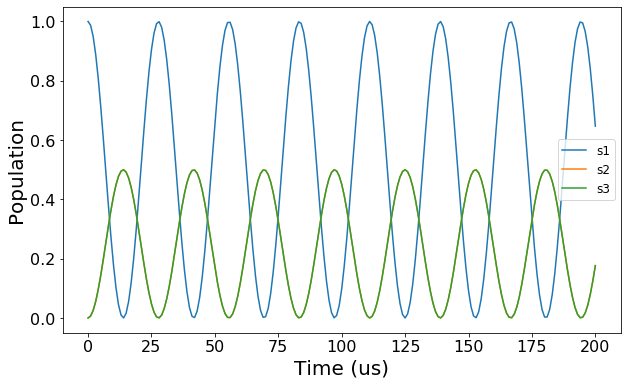

In [129]:
ii = 1
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 0e-1, # MHz
             w3 = 0e-1, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

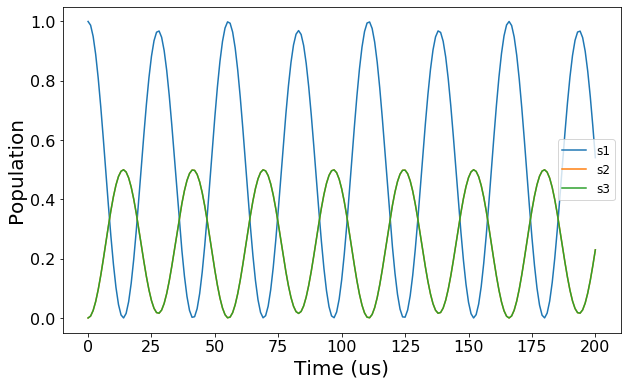

In [131]:
ii = 1
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1.0e-2, # MHz
             w3 = -1.0e-2, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

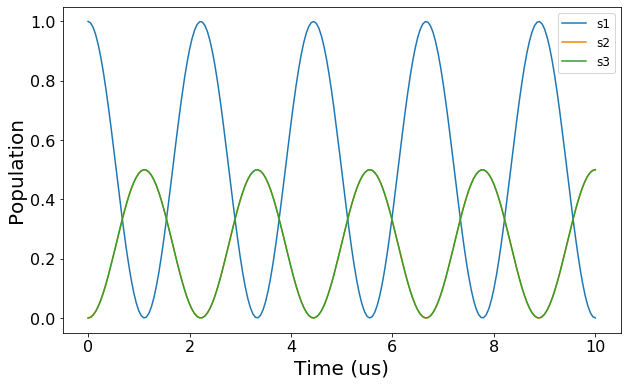

In [13]:
ii = 1
pi_time = 1 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 0, # MHz
             w3 = 0, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 10, 201, isPlot = True)

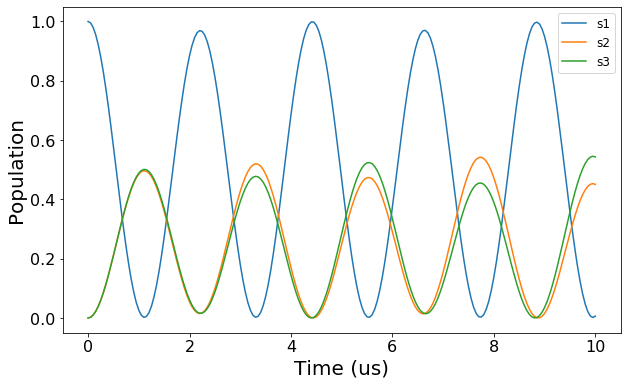

In [14]:
ii = 1
pi_time = 1 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 0.25, # MHz
             w3 = 0, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 10, 201, isPlot = True)

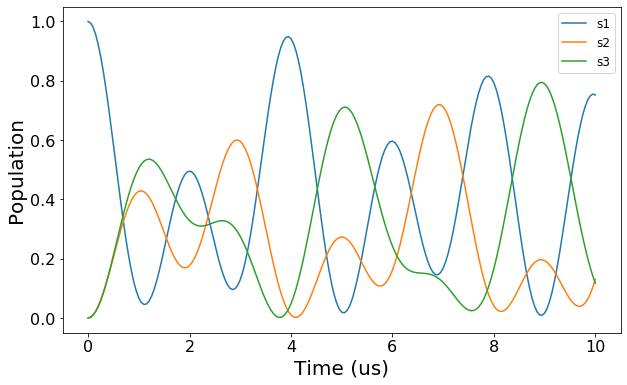

In [15]:
ii = 1
pi_time = 1 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1.25, # MHz
             w3 = 0, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 10, 201, isPlot = True)